In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import gzip
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread

from common import * 
import preprocess
import model_io

In [6]:
DATA_DIR = 'data/clean_1'

log = preprocess.load_driving_log(os.path.join(DATA_DIR, DRIVING_LOG_CSV))
log = preprocess.smooth_control_inputs(log, 1)
print(log.head())

                                        center_image  \
0  data/clean_1/IMG/center_2016_12_04_21_13_56_21...   
1  data/clean_1/IMG/center_2016_12_04_21_13_56_33...   
2  data/clean_1/IMG/center_2016_12_04_21_13_56_45...   
3  data/clean_1/IMG/center_2016_12_04_21_13_56_57...   
4  data/clean_1/IMG/center_2016_12_04_21_13_56_72...   

                                          left_image  \
0  data/clean_1/IMG/left_2016_12_04_21_13_56_217.jpg   
1  data/clean_1/IMG/left_2016_12_04_21_13_56_334.jpg   
2  data/clean_1/IMG/left_2016_12_04_21_13_56_454.jpg   
3  data/clean_1/IMG/left_2016_12_04_21_13_56_577.jpg   
4  data/clean_1/IMG/left_2016_12_04_21_13_56_725.jpg   

                                         right_image  steering_angle  \
0  data/clean_1/IMG/right_2016_12_04_21_13_56_217...             0.0   
1  data/clean_1/IMG/right_2016_12_04_21_13_56_334...             0.0   
2  data/clean_1/IMG/right_2016_12_04_21_13_56_454...             0.0   
3  data/clean_1/IMG/right_2016_12_04_2

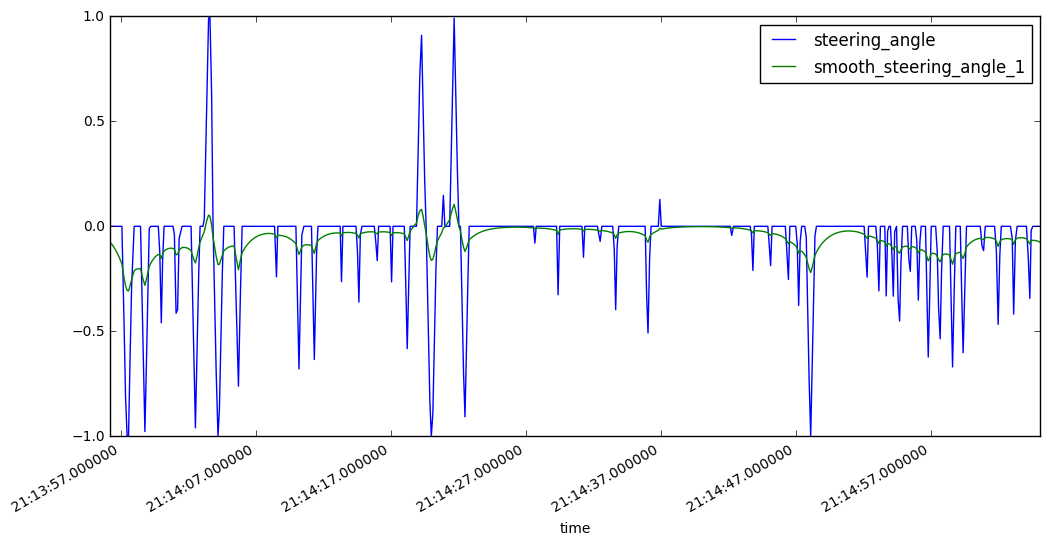

In [7]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

In [8]:
log.to_pickle(os.path.join(DATA_DIR, DRIVING_LOG_PICKLE))

In [9]:
import math
import cv2

def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -20 degrees to 20 degrees.
    """
    return math.radians(steering_angle * 20.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filename,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # at least for Mac
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()
make_steering_movie('test.mp4', log[0:50], 'smooth_steering_angle_1')

frame 0


# Base Model

The full inception model is too slow for my laptop, so I am just using the first few layers.

Loading the whole inception model is very slow, so we also cut out only the weights we need and save them for loading later.

In [6]:
import inception
import model_io

model_io.save_model(
    BASE_MODEL_JSON_FILE,
    BASE_MODEL_WEIGHTS_FILE,
    inception.make_cut_model())

Using TensorFlow backend.


In [10]:
model_io.load_base_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 79, 159, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 79, 159, 32)   64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 77, 157, 32)   9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

# Bottleneck

Training is hopelessly slow if we don't botteneck the features.

In [10]:
import bottleneck_features

In [ ]:
bottleneck_features.run(log, DATA_DIR)

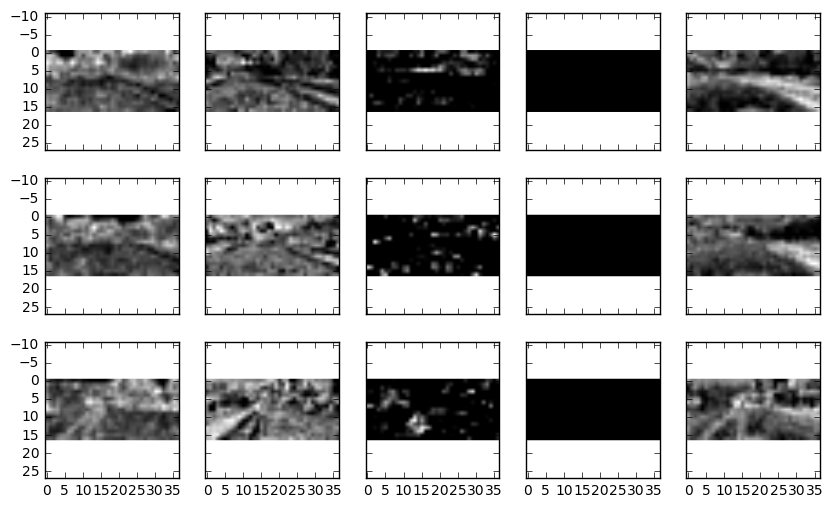

In [19]:
def plot_bottleneck_output(num_images, num_channels, image_stride=50):
    bottleneck_center_image = \
        np.load(os.path.join(DATA_DIR, get_bottleneck_filename('center_image')))['arr_0']
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        for j in range(num_channels):
            axes[i][j].imshow(bottleneck_center_image[i * image_stride][:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

In [ ]:
# from keras.applications.inception_v3 import preprocess_input
# from scipy.misc import imread
# import model
# from datetime import datetime
# base_model = model.make_base_model()
# base_model.summary()
# def test_convert():
#     """
#     See how long it takes to run a prediction.
#     """
#     image = imread('data/clean_1/IMG/center_2016_12_04_21_19_10_094.jpg')
#     plt.imshow(image)

#     print(datetime.now(), 'preprocess')
#     X = preprocess_input(image.astype('float32'))
#     print(datetime.now(), 'predict')
#     base_X = base_model.predict(np.array([X]))
#     print(datetime.now(), base_X.shape)
#     base_X = np.reshape(base_X, (17, 37, 256))
#     plt.imshow(base_X[:,:,1], cmap='gray')
# test_convert()

# Model

In [33]:
import model

In [29]:
bottleneck_center_image = \
    np.load(os.path.join(DATA_DIR, get_bottleneck_filename('center_image')))['arr_0']

In [31]:
labels = log['smooth_steering_angle_1'].values

In [55]:
result_model = model.train(bottleneck_center_image, labels, nb_epoch=20)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_100 (Convolution2D (None, 17, 37, 64)    16448       convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
flatten_14 (Flatten)             (None, 40256)         0           convolution2d_100[0][0]          
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 1)             40257       flatten_14[0][0]                 
Total params: 56705
____________________________________________________________________________________________________
Train on 2418 samples, validate on 605 samples
Epoch 1/20
2418/2418 [==============================] - 9s - loss: 0.1814 - val_loss: 0.0151
Epoch 2/20
2418/2418 [==========

In [56]:
model_io.save_model('model.json', 'model.h5', result_model)

In [45]:
base_model = model_io.load_base_model()

2016-12-07 23:30:18.866664 preprocess
2016-12-07 23:30:18.867468 base predict
2016-12-07 23:30:19.066349 predict
2016-12-07 23:30:19.631505 result 0.07920446991920471


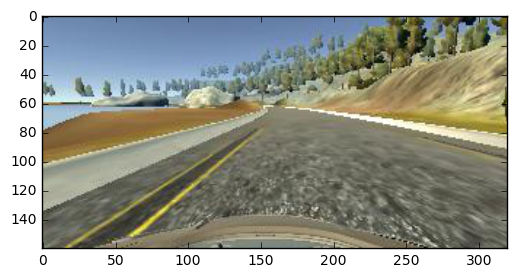

In [57]:
from datetime import datetime

from keras.applications.inception_v3 import preprocess_input

def test_predict():
    """
    See how long it takes to run a prediction.
    """
    # left
#     image = imread('data/clean_1/IMG/center_2016_12_04_21_19_10_094.jpg')
    # right
    image = imread('data/clean_1/IMG/center_2016_12_04_21_14_21_685.jpg')
    plt.imshow(image)

    print(datetime.now(), 'preprocess')
    X = preprocess_input(image.astype('float32'))
    print(datetime.now(), 'base predict')
    base_X = base_model.predict(np.array([X]))
    print(datetime.now(), 'predict')
    steering_angle = float(result_model.predict(base_X))
    print(datetime.now(), 'result', steering_angle)
    
test_predict()

In [ ]:
import pandas as pd

DATA_DIR = 'data/clean_1'
DRIVING_LOG = pd.read_pickle(os.path.join(DATA_DIR, DRIVING_LOG_PICKLE))


In [46]:
bottleneck_center_image = \
    np.load(os.path.join(DATA_DIR, get_bottleneck_filename('center_image')))['arr_0']

In [47]:
result_model = model_io.load_model('model.json', 'model.h5')

In [53]:
log['predicted_steering_angle'] = 0.0
for i in range(len(log)):
    base_X = bottleneck_center_image[i:(i+1),:,:,:]
    prediction = result_model.predict(base_X)
    log['predicted_steering_angle'].values[i] = float(prediction)

0      -0.113448
1      -0.118868
2      -0.149682
3      -0.159350
4      -0.182436
5      -0.210602
6      -0.204298
7      -0.219321
8      -0.242081
9      -0.302599
10     -0.323552
11     -0.347101
12     -0.291428
13     -0.285035
14     -0.235743
15     -0.222093
16     -0.223880
17     -0.239804
18     -0.278285
19     -0.258621
20     -0.266907
21     -0.220314
22     -0.244487
23     -0.245175
24     -0.210574
25     -0.236286
26     -0.212597
27     -0.210712
28     -0.227501
29     -0.258750
          ...   
2993   -0.042268
2994   -0.032126
2995   -0.054820
2996   -0.045648
2997   -0.035464
2998   -0.049613
2999   -0.052024
3000   -0.076413
3001   -0.052105
3002   -0.039087
3003   -0.080331
3004   -0.064149
3005   -0.087246
3006   -0.052997
3007   -0.078082
3008   -0.084869
3009   -0.068125
3010   -0.071734
3011   -0.108755
3012   -0.099620
3013   -0.120407
3014   -0.102855
3015   -0.115969
3016   -0.129807
3017   -0.123701
3018   -0.118239
3019   -0.133976
3020   -0.1078

In [57]:
make_steering_movie('test.mp4', log[0:500], 'smooth_steering_angle_1', 'predicted_steering_angle')

frame 0
frame 50
frame 100
frame 150
frame 200
frame 250
frame 300
frame 350
frame 400
frame 450


In [94]:
import bottleneck_features
bottleneck_features.bottleneck(log[0:5], DATA_DIR, 2)
# def chunks(itr, size):
#     for i in range(0, len(itr), size):
#         yield itr[i:(i+size)]
# from keras.applications.inception_v3 import preprocess_input
        
# for batch in chunks(log[0:5], 2):
#     filenames = [
#         batch[column].values[i]
#         for i in range(len(batch))
#         for column in IMAGE_COLUMNS 
#     ]
#     X_batch = [imread(filename) for filename in filenames]
#     X_batch = np.array(X_batch).astype(np.float32)
#     X_batch = preprocess_input(X_batch)

#     X_base = base_model.predict(X_batch)

#     for prediction in chunks(X_base, len(IMAGE_COLUMNS)):
#         print({
#             IMAGE_COLUMNS[i]: prediction[i] for i in range(len(prediction))
#         })

#     X_batch = [imread(filename) for filename in filenames]
#     X_batch = np.array(X_batch).astype(np.float32)
#     X_batch = preprocess_input(X_batch)

#     X_base = base_model.predict(X_batch)
#     print(X_base.shape)

In [95]:
res = np.load('data/clean_1/bottleneck/0.npz')

In [100]:
np.all(bottleneck_center_image[0] == res['center_image'])

True